<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Guessing-only-the-most-common-class-correct-performs-poorly-for-both-log-loss-and-AUC" data-toc-modified-id="Guessing-only-the-most-common-class-correct-performs-poorly-for-both-log-loss-and-AUC-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Guessing only the most common class correct performs poorly for both log loss and AUC</a></span></li><li><span><a href="#Guessing-all-classes-are-equal-likely-is-a-good-naive-prediction-for-log-loss,-but-not-AUC" data-toc-modified-id="Guessing-all-classes-are-equal-likely-is-a-good-naive-prediction-for-log-loss,-but-not-AUC-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Guessing all classes are equal likely is a good naive prediction for log loss, but not AUC</a></span></li><li><span><a href="#Effective-weight-of-rare-classes-depends-strongly-on-whether-we're-considering-true-positives-or-false-positives" data-toc-modified-id="Effective-weight-of-rare-classes-depends-strongly-on-whether-we're-considering-true-positives-or-false-positives-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Effective weight of rare classes depends strongly on whether we're considering true positives or false positives</a></span></li><li><span><a href="#check-AUC-treatment-of-false-positives-for-rare-classes" data-toc-modified-id="check-AUC-treatment-of-false-positives-for-rare-classes-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>check AUC treatment of false positives for rare classes</a></span></li><li><span><a href="#Getting-only-the-most-common-two-class-correct" data-toc-modified-id="Getting-only-the-most-common-two-class-correct-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Getting only the most common two class correct</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
solution = pd.read_csv('plasticc_test_truthtable.csv')
solution = pd.get_dummies(solution, prefix='class', columns=['target'])

In [3]:
solution.head()

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,13,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,14,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,17,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,23,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,34,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


Objects per class

In [4]:
solution.drop('object_id', axis=1).sum()

class_6        1303
class_15      13555
class_16      96572
class_42    1000150
class_52      63664
class_53       1453
class_62     175094
class_64        133
class_65      93494
class_67      40193
class_88     101424
class_90    1659831
class_92     197155
class_95      35782
class_99      13087
dtype: int64

In [5]:
y_true = solution.drop('object_id', axis=1).values

In [6]:
y_pred = y_true.copy()

## Guessing only the most common class correct performs poorly for both log loss and AUC

In [7]:
ll_results = []
auc_results = []
for i in range(15):
    y_pred *= 0
    y_pred[:, i] += 1
    ll_results.append(sklearn.metrics.log_loss(y_true, y_pred))
    auc_results.append(sklearn.metrics.roc_auc_score(y_true, y_pred, average='macro'))

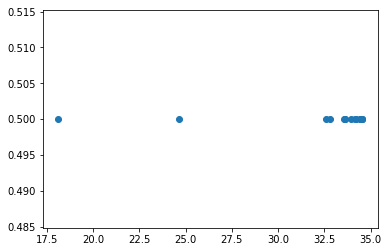

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(ll_results, auc_results, marker='o')

## Guessing all classes are equal likely is a good naive prediction for log loss, but not AUC

In [9]:
y_pred *= 0
y_pred = y_pred.astype(np.float64)
y_pred += float(1/15)
print(sklearn.metrics.log_loss(y_true, y_pred))
print(sklearn.metrics.roc_auc_score(y_true, y_pred, average='macro'))

2.708050201102198
0.5


## Effective weight of rare classes depends strongly on whether we're considering true positives or false positives

All KN wrong, set to Ia.

In [10]:
y_pred = solution.copy()
kn_locs = y_pred[y_pred.class_64 == 1].index.values
y_pred.loc[kn_locs, 'class_64'] = 0
y_pred.loc[kn_locs, 'class_90'] = 1
y_pred = y_pred.drop('object_id', axis=1).values

In [11]:
print(sklearn.metrics.log_loss(y_true, y_pred))
print(sklearn.metrics.roc_auc_score(y_true, y_pred, average='macro'))

0.001315145126406607
0.9666642481229464


## check AUC treatment of false positives for rare classes

10% of Ia set to KN

In [12]:
y_pred = solution.copy()
fp_locs = y_pred[y_pred.class_90 == 1].sample(frac=0.1).index.values
y_pred.loc[fp_locs, 'class_64'] = 1
y_pred.loc[fp_locs, 'class_90'] = 0
y_pred = y_pred.drop('object_id', axis=1).values

In [13]:
print(sklearn.metrics.log_loss(y_true, y_pred))
print(sklearn.metrics.roc_auc_score(y_true, y_pred, average='macro'))

1.6412912294279316
0.9950826000819074


Log loss harshly penalizes the false positives, AUC rewards them

## Getting only the most common two class correct
all others assigned to class 90

In [14]:
y_pred = solution.copy()
y_pred *= 0
y_pred['class_90'] = 1
y_pred['class_42'] = solution['class_42']
y_pred['class_90'] -= solution['class_42']
y_pred = y_pred.drop('object_id', axis=1).values

In [15]:
print(sklearn.metrics.log_loss(y_true, y_pred))
print(sklearn.metrics.roc_auc_score(y_true, y_pred, average='macro'))

8.23606174494725
0.5515206002643668


Also correct for several more classes, to roughly match guessing all classes equally likely

In [16]:
y_pred = solution.copy()
y_pred *= 0
y_pred['class_90'] = 1

y_pred['class_16'] = solution['class_16']
y_pred['class_90'] -= solution['class_16']

y_pred['class_42'] = solution['class_42']
y_pred['class_90'] -= solution['class_42']

y_pred['class_62'] = solution['class_62']
y_pred['class_90'] -= solution['class_62']


y_pred['class_92'] = solution['class_92']
y_pred['class_90'] -= solution['class_92']

y_pred['class_88'] = solution['class_88']
y_pred['class_90'] -= solution['class_88']


y_pred = y_pred.drop('object_id', axis=1).values

print(sklearn.metrics.log_loss(y_true, y_pred))
print(sklearn.metrics.roc_auc_score(y_true, y_pred, average='macro'))

2.5973028532226587
0.6952235761823997


In [17]:
solution[['class_16', 'class_42', 'class_62', 'class_88', 'class_90', 'class_92']].sum().sum()

3230226

In [18]:
3230226 / len(solution)

0.9248003802009225